In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
import pandas as pd

# astropy
# from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
# from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
# import aplpy
from regions import Regions

# matplotlib
import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# from matplotlib.patches import Circle, Ellipse
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
# from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import AsinhNorm

from copy import copy

%matplotlib inline

In [2]:
hc3nfile = 'data/NGC1333_HC3N_L24-merged_small_K.fits'
hc3nmom0file = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
hc3nrmsfile = 'data/NGC1333_HC3N_L24-merged_small_K_rms.fits'
sourcecat = 'data/my_catalog_vel.csv'
xraycat = 'data/xray_sources_NGC1333_phot_SE.csv'
n2hpfile = 'data/NGC1333-N2Hp_match_kms.fits'
n2hpmom0file = 'data/NGC1333-N2Hp_match_TdV.fits'
n2hpparamsfile = 'first_look/fit_N2Hp/NGC1333-N2Hp_match_fit_near_thick.fits'

n2hpmlex1file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
n2hpmlex2file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits'

hc3nmlex1file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_selected.fits'
hc3nmlex2file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x2_selected.fits'
hc3nmlex3file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x3_selected.fits'

ncompfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC.fits'
ncompflagfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC_flag.fits'

ncompfilebayes = 'bayes_frame/nested-sampling/HC3N/npeaks_cut5.fits'

n2hpncompfilebayes = 'bayes_frame/nested-sampling/N2Hp/npeaks_cut5_noislands_QA.fits'

In [4]:
mom0, header2d = fits.getdata(hc3nmom0file, header=True)
wcs = WCS(header2d)

bmaj, bmin, bpa = np.array([header2d['bmaj'], header2d['bmin'], header2d['bpa']]) * u.deg
cubehc3n = SpectralCube.read(hc3nfile)
catalog_protostars = pd.read_csv(sourcecat)
# catalog_protostars_extended = pd.read_csv(sourcecat_extended)
catalog_xray = pd.read_csv(xraycat)
ncomp = fits.getdata(ncompfile)
ncompflag = fits.getdata(ncompflagfile)

ncompbayes = fits.getdata(ncompfilebayes)
n2hpncompbayes = fits.getdata(n2hpncompfilebayes)

mom0n2hp, header2dn2hp = fits.getdata(n2hpmom0file, header=True)
mom0n2hp = mom0n2hp / 1000 # to K km s-1
wcsn2hp = WCS(header2dn2hp)
bmajn2hp, bminn2hp, bpan2hp = np.array([header2dn2hp['bmaj'], header2dn2hp['bmin'], header2dn2hp['bpa']]) * u.deg
cubehc3n = SpectralCube.read(n2hpfile)

n2hpmlex1 = fits.getdata(n2hpmlex1file)
n2hpmlex2 = fits.getdata(n2hpmlex2file)
hc3nmlex1 = fits.getdata(hc3nmlex1file)
hc3nmlex2 = fits.getdata(hc3nmlex2file)
hc3nmlex3 = fits.getdata(hc3nmlex3file)

In [10]:
catalog_protostars

,Source,RAJ2000,DEJ2000,Other,Mult,Class,Lbol,e_Lbol,Tbol,e_Tbol,SimbadName,vlsr,e_vlsr,ref_vlsr
0,Per-emb-3,52.252396,31.200057,---,N,0,0.50,0.06,32.0,2.0,[EES2009] Per-emb 3,7.30,0.01000,Stephens+19
1,IRAS4A,52.293904,31.225259,NGC 1333 IRAS4A,Y,0,7.00,0.70,29.0,2.0,[EES2009] Per-emb 12,6.90,0.00500,Stephens+19
2,IRAS4B,52.300067,31.218898,NGC 1333 IRAS4B,Y,0,4.00,0.30,28.0,1.0,[EES2009] Per-emb 13,7.10,0.00900,Stephens+19
3,Per-emb-14,52.306450,31.232819,NGC 1333 IRAS4C,N,0,0.70,0.08,31.0,2.0,[EES2009] Per-emb 14,7.90,0.03000,Stephens+19
4,Per-emb-15,52.266896,31.246177,"RNO15-FIR, SK 14",N,0,0.40,0.10,36.0,4.0,[EES2009] Per-emb 15,6.80,0.01000,Stephens+19
5,Per-emb-27,52.231538,31.243618,NGC 1333 IRAS2A,Y,0/I,19.00,0.40,69.0,1.0,[EES2009] Per-emb 27,8.10,0.02000,Stephens+19
6,Per-emb-36,52.239058,31.237714,NGC 1333 IRAS2B,Y,I,5.30,1.00,106.0,12.0,[EES2009] Per-emb 36,6.90,0.02000,Stephens+19
7,Per-emb-44,52.265683,31.267724,SVS13A,Y,0/I,32.50,7.10,188.0,9.0,[EES2009] Per-emb 44,8.70,0.02000,Stephens+19
8,Per-bolo-45,52.282083,31.288000,Per-Bolo-45,N,0,0.05,0.05,15.0,NaN,[EYG2006] Bolo 45,NaN,NaN,NaN
9,SVS13C,52.258208,31.260570,SVS13C,Y,0,1.50,0.20,21.0,1.0,[SVS76] NGC 1333 13C,8.90,0.02000,Stephens+19


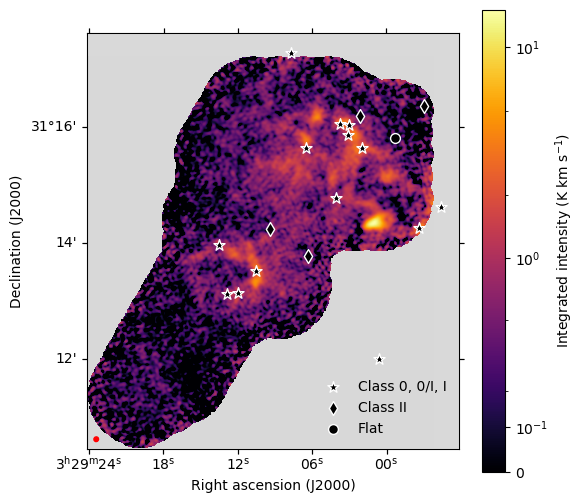

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(mom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_mylist.pdf', bbox_inches='tight', dpi=100)

In [14]:
outflowsources = ['Per3', 'Per12', 'Per13', 'Per15', 'Per27', 'Per36', 'Per44SVS13B', 'SVS13C']
outflowfolder = 'data/MASSES/'
outflowbluebase = '{0}.12CO21.robust1_blue'
outflowredbase = '{0}.12CO21.robust1_red'
contourbluelist = np.array([[0.25, 0.2], [3, 12], [3, 6], [1.6, 1], [2.2, 4], [2.4, 2.4], [3.3, 10], [2, 4]]) # start, step
contourredlist = np.array([[0.7,1.5], [3.5,10], [1.6, 5], [0.6,0.7], [1.5, 3], [5, 5], [6, 10], [3, 3]])

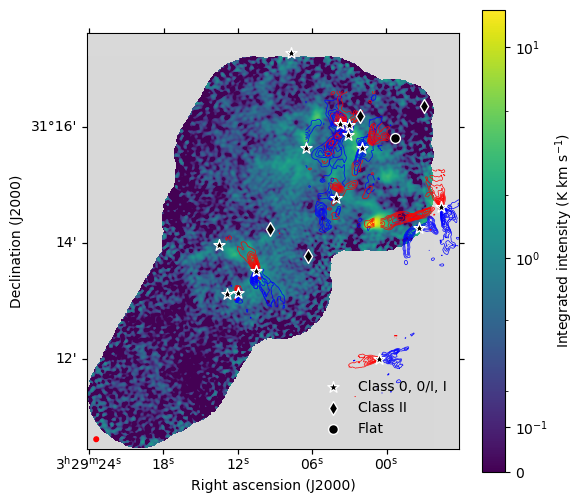

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(mom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.5)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.5)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')

# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows_wsourcesextended.pdf', bbox_inches='tight', dpi=100)

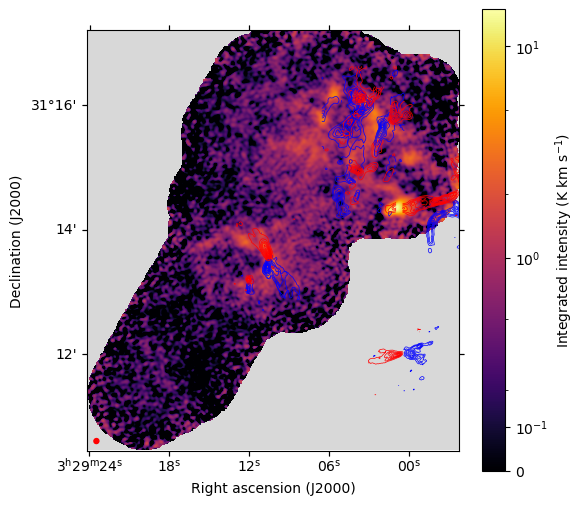

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(mom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.5)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.5)


# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows.pdf', bbox_inches='tight', dpi=100)

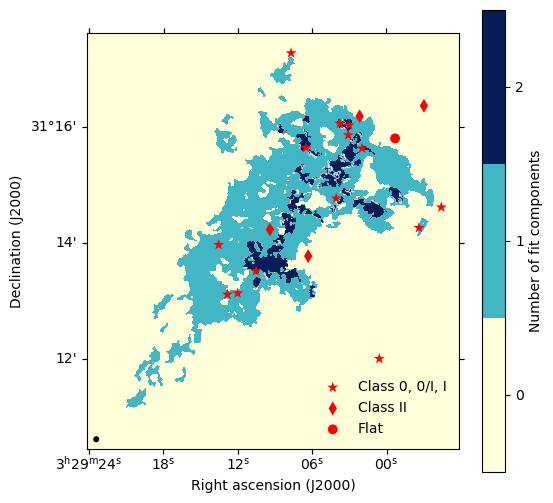

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
ncomp[np.where(np.isnan(ncomp))] = 0
ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncomp,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompAIC_wflag.pdf', bbox_inches='tight', dpi=100)

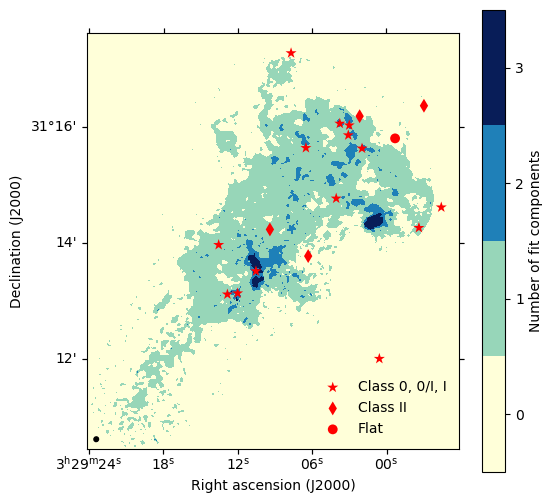

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompbayes.pdf', bbox_inches='tight', dpi=100)

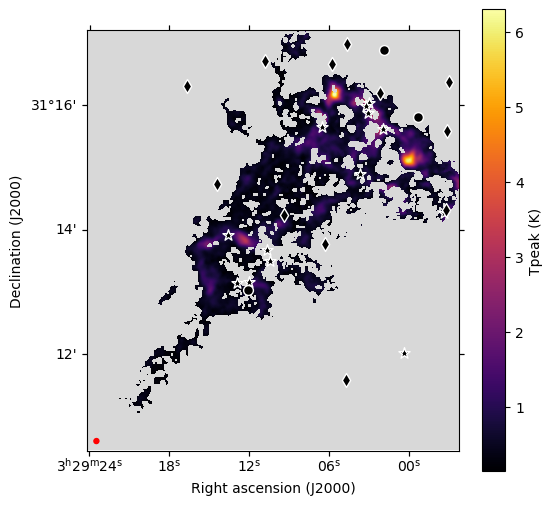

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')

im = ax.imshow(hc3nmlex1[0], cmap=cmap)
fig.colorbar(im, ax=ax, label=r'Tpeak (K)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars_extended.index.values:
    if catalog_protostars_extended.loc[i, 'Class'] == 'I' or catalog_protostars_extended.loc[i, 'Class'] == '0':
        ax.scatter(catalog_protostars_extended.loc[i, 'RAJ2000'], catalog_protostars_extended.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars_extended.loc[i, 'Class'] == 'II' or catalog_protostars_extended.loc[i, 'Class'] == 'III':
        ax.scatter(catalog_protostars_extended.loc[i, 'RAJ2000'], catalog_protostars_extended.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars_extended.loc[i, 'Class'] == 'F':
        ax.scatter(catalog_protostars_extended.loc[i, 'RAJ2000'], catalog_protostars_extended.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars_extended.loc[i, 'Class'] == 'S': continue
    

# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_amplitude_mlex1_extendedlist.pdf', bbox_inches='tight', dpi=100)

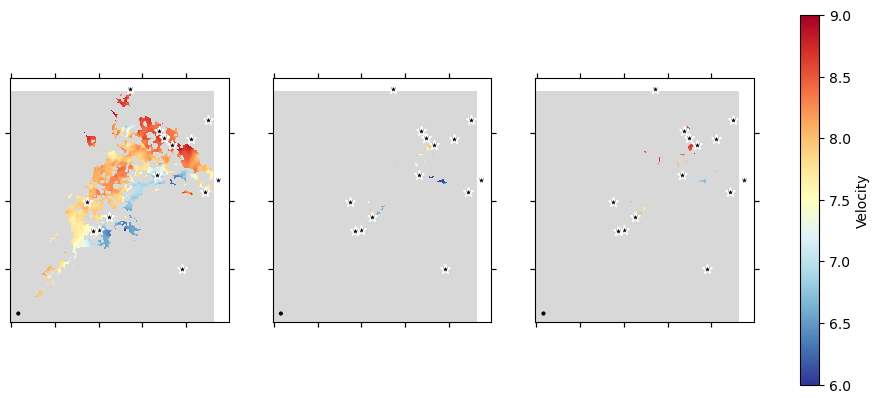

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

hc3nmlexlist = [hc3nmlex1[1], hc3nmlex2[1], hc3nmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(hc3nmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i==3:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    else:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label='Velocity',  shrink=0.8)

    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

    for i in catalog_protostars.index.values:
        ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=50)

fig.savefig('figures/HC3N_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)

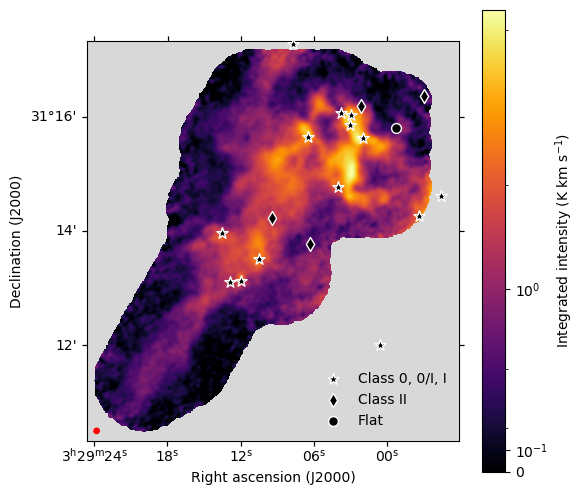

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.8, vmin=0)

im = ax.imshow(mom0n2hp, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
fig.savefig('figures/N2Hp_mom0.pdf', bbox_inches='tight', dpi=100)

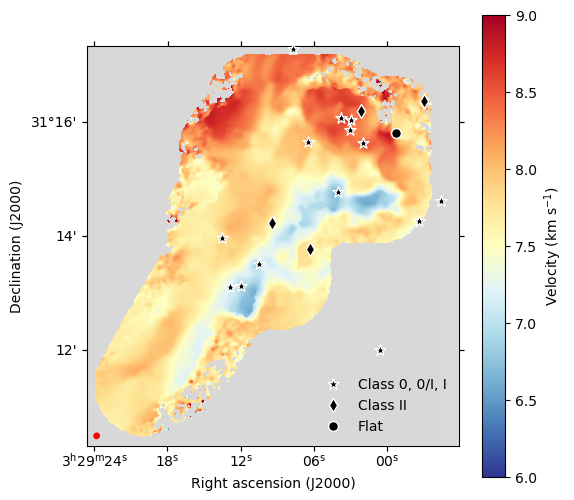

In [44]:
paramscuben2hp = fits.getdata(n2hpparamsfile)

fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

im = ax.imshow(paramscuben2hp[2], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'Velocity (km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
fig.savefig('figures/N2Hp_vlsr_thick.pdf', bbox_inches='tight', dpi=100)

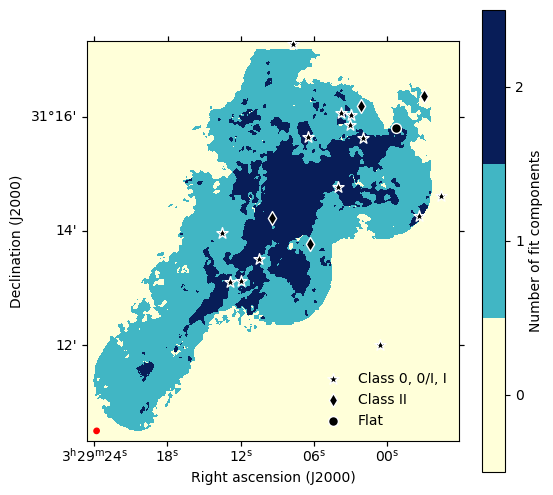

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
n2hpncompbayes[np.where(np.isnan(n2hpncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(n2hpncompbayes,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
    
fig.savefig('figures/N2Hp_ncompbayes.pdf', bbox_inches='tight', dpi=100)

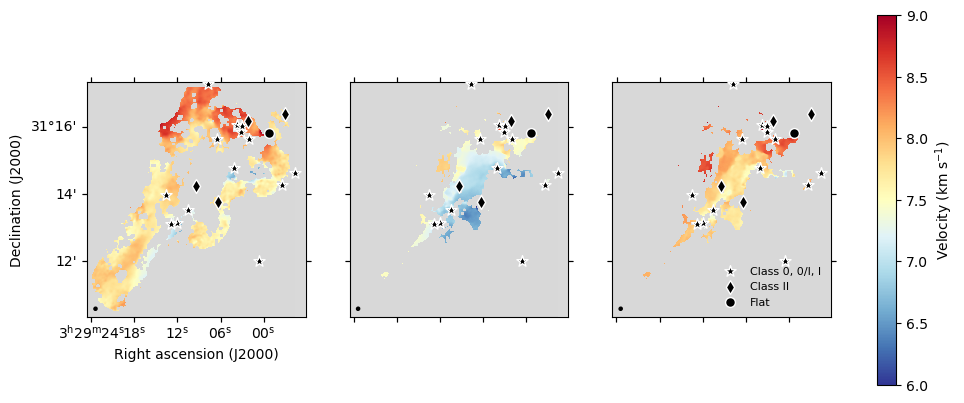

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

n2hpmlexlist = [n2hpmlex1[1], n2hpmlex2[1], n2hpmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(n2hpmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    

    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label=r'Velocity (km s$^{-1}$)',  shrink=0.8)

    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)

    ax.set_facecolor('0.85')
    for i in catalog_protostars.index.values:
        if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
        else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4, fontsize=8)

fig.savefig('figures/N2Hp_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)